# Fine-tuning an emotion classifier on the EEC dataset 

# Installations, imports and models

In [ ]:
! pip install transformers datasets wandb -q

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn 
import torch  
import wandb

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from datasets import load_dataset
from transformers import DistilBertTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments

In [ ]:
model_ckpt = 'distilbert-base-uncased'
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


# Equity Evaluation Corpus (EEC) - A closer look to the dataset 🔬
-------------------------------------------------

The Equity Evaluation Corpus is a dataset of 8,640 English sentences that can be used to 
determine whether automatic systems consistently give higher (or lower) sentiment intensity scores to sentences involving  a particular race or gender.



In [ ]:
!wget "https://saifmohammad.com/WebDocs/EEC/Equity-Evaluation-Corpus.zip"
!unzip "Equity-Evaluation-Corpus.zip"

--2022-05-31 00:05:15--  https://saifmohammad.com/WebDocs/EEC/Equity-Evaluation-Corpus.zip
Resolving saifmohammad.com (saifmohammad.com)... 192.185.17.122
Connecting to saifmohammad.com (saifmohammad.com)|192.185.17.122|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1669592 (1.6M) [application/zip]
Saving to: ‘Equity-Evaluation-Corpus.zip.2’

Equity-Evaluation-C 100%[===================>]   1.59M  1.18MB/s    in 1.3s    

2022-05-31 00:05:18 (1.18 MB/s) - ‘Equity-Evaluation-Corpus.zip.2’ saved [1669592/1669592]

Archive:  Equity-Evaluation-Corpus.zip
replace Equity-Evaluation-Corpus/README.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: yy
  inflating: Equity-Evaluation-Corpus/README.txt  
replace __MACOSX/Equity-Evaluation-Corpus/._README.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: __MACOSX/Equity-Evaluation-Corpus/._README.txt  
replace Equity-Evaluation-Corpus/Biases-StarSem-2018-with-appendix.pdf? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflati

Let's "become one with the data"!

In [ ]:
initial_df = pd.read_csv('Equity-Evaluation-Corpus/Equity-Evaluation-Corpus.csv')
initial_df.dropna(inplace=True)
initial_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5600 entries, 0 to 8439
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ID            5600 non-null   object
 1   Sentence      5600 non-null   object
 2   Template      5600 non-null   object
 3   Person        5600 non-null   object
 4   Gender        5600 non-null   object
 5   Race          5600 non-null   object
 6   Emotion       5600 non-null   object
 7   Emotion word  5600 non-null   object
dtypes: object(8)
memory usage: 393.8+ KB


Looking at class distribution:

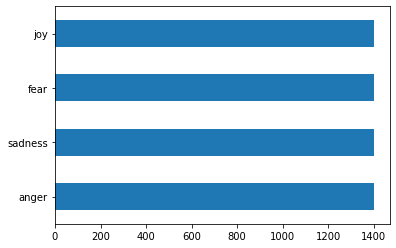

In [ ]:
initial_df['Emotion'].value_counts(ascending=True).plot.barh()

Our dataset seems suspiciously balanced. 

Why? 🤔

Most probably because it has been artificially created based on a template.
Indeed, by takeing a look at the dataset's description we read:


>*The sentences are generated from eleven templates by instantiating the noun phrase variable with one of the pre-chosen values:*
> - *common African American female first names,*
> - *common African American male first names,*
> - *common European American female names,*
> - *common European American male first names,*
> - *noun phrases referring to females, such as "my daughter",*
> - *noun phrases referring to males, such as "my son".*

>*Some sentences include explicit expressions of sentiment and emotion, and some sentences do not. *
>*One can derive pairs of sentences from the EEC such that they differ only in one word corresponding to gender or race (e.g., "My daughter feels devastated" and "My son feels devastated"*
>

Based on this description, we can expect to have data leakage because, most probably, those template sentences will be repeated in the training and validation/test set with the only difference of having different names/genders.

Let's take a look at the tempates:


In [ ]:
initial_df['Template'].value_counts()

<person subject> feels <emotion word>.                                                  800
The situation makes <person object> feel <emotion word>.                                800
I made <person object> feel <emotion word>.                                             800
<person subject> made me feel <emotion word>.                                           800
<person subject> found himself/herself in a/an <emotional situation word> situation.    800
<person subject> told us all about the recent <emotional situation word> events.        800
The conversation with <person object> was <emotional situation word>.                   800
Name: Template, dtype: int64

In that case we want to ***avoid*** stratification by "Template" so that similar sentences are not repeated in the splits:

In [ ]:
val = initial_df[:2400]
train = initial_df[2401:4000]
test = initial_df[4001:]

Let's check the class distribution in all three sets to make sure we did not cause more harm than good:

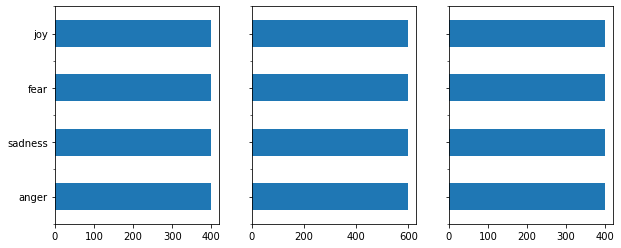

In [ ]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(10,4), sharey=True)
train['Emotion'].value_counts(ascending=True).plot.barh(ax=ax1)
val['Emotion'].value_counts(ascending=True).plot.barh(ax=ax2)
test['Emotion'].value_counts(ascending=True).plot.barh(ax=ax3)

That looks ok. 🙆‍♀️

Still, it is good to be aware of the fact that the dataset is artificially balanced in the sense that we are going to find the same names, genders and races across the three splits.

Next, we need to know: How long are our sentences?

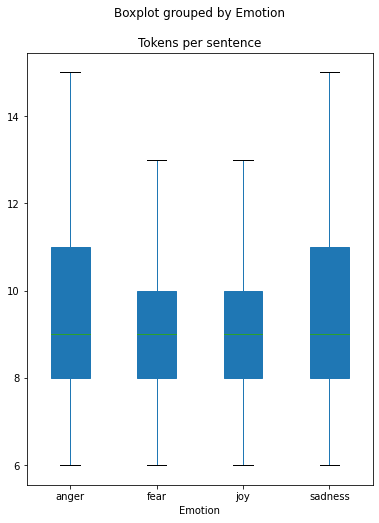

In [ ]:
distilbert_tokenizer = DistilBertTokenizer.from_pretrained(model_ckpt)
initial_df['Tokens per sentence'] = initial_df['Sentence'].apply(lambda x: len(distilbert_tokenizer.encode(x)))
initial_df.boxplot('Tokens per sentence', by='Emotion', grid=False, showfliers=False, patch_artist = True, figsize=(6,8))

From the plot we see that for each emotion, most sentences are around 9 words long, and the longest sentences are well below DistillBERT's maximum context size.



We need to modify our dataset so it can later be digested by the `load_dataset` function


In [ ]:
def modify_dataset(df, save_name):
  df.rename(columns={'Sentence':'text'}, inplace=True)
  df['label'] = df['Emotion']
  df['label'] = pd.Categorical(df['label'])
  df['label'] = df['label'].cat.codes
  df.to_csv(f'{save_name}.csv')

In [ ]:
splits = {'train' : train, 'val': val, 'test': test}
for key,value in splits.items():
  modify_dataset(value, key)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

Now we load our dataset as a `Dataset` object. We will be using that for training:

In [ ]:
dataset = load_dataset('csv', data_files={'train':'train.csv', 'val':'val.csv', 'test':'test.csv'})

Using custom data configuration default-634bcb48f0bb287e


Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-634bcb48f0bb287e/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Tokenizing the whole dataset

In [ ]:
def tokenize(batch):
  return distilbert_tokenizer(batch['text'], padding=True, truncation=True)

dataset_encoded = dataset.map(tokenize, batched=True, batch_size=None) # bs=None maps the whole ds as a single batch

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

# Now the fun part! 🍦 

Loading the pretrained DistilBERT model. 

The main advantage of this model is that it achieves comparable perforance to BERT, while being significantly smaller and more efficient. 

In [ ]:
num_labels = len(initial_df['Emotion'].unique())
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels).to(device)

Defining performance metrics.

To monitor the metrics during training we need to define a `compute_metrics` function as our `Trainer` expects. 
As an input, this function expects an `EvalPrediction` object which is a tuple with `predictions` and `label_ids`. 
It also needs to return a dict that maps each metric's name to its value. 
Here, we will be computing F1 and accuracy.

In [ ]:
def compute_metrics(pred):
  labels  = pred.label_ids
  preds = pred.predictions.argmax(-1)
  f1 = f1_score(labels, preds, average='weighted')
  acc = accuracy_score(labels, preds)
  return {'accuracy': acc, 'f1': f1}

Train the model


In [ ]:
batch_size = 64
logging_steps = len(dataset['train']) // batch_size
model_name = f'{model_ckpt}-finetuned-EEC'
training_args = TrainingArguments(output_dir = model_name, 
                                   num_train_epochs=5,
                                   learning_rate = 2e-5,
                                   per_device_train_batch_size=batch_size,
                                   per_device_eval_batch_size=batch_size,
                                   weight_decay=0.01,
                                   evaluation_strategy='epoch',
                                   disable_tqdm='False',
                                   logging_steps=logging_steps,
                                   log_level='error'
                                   )

In [ ]:
trainer = Trainer(model=model, args=training_args, 
                  compute_metrics=compute_metrics,
                  train_dataset=dataset_encoded['train'],
                  eval_dataset=dataset_encoded['test'],
                  tokenizer=distilbert_tokenizer
                  )

In [ ]:
wandb.init()
trainer.train()

eval/accuracy,▁▆▇██
eval/f1,▁▆▇██
eval/loss,█▄▂▁▁
eval/runtime,▁▂▃▇█
eval/samples_per_second,█▇▅▂▁
eval/steps_per_second,█▇▅▂▁
train/epoch,▁▁▃▃▄▅▆▆███
train/global_step,▁▁▃▃▄▅▆▆███
train/learning_rate,█▆▅▃▁
train/loss,█▅▂▁▁
train/total_flos,▁


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


{'loss': 1.218, 'learning_rate': 1.616e-05, 'epoch': 0.96}
{'eval_loss': 1.026824951171875, 'eval_accuracy': 0.8761726078799249, 'eval_f1': 0.8743677622873103, 'eval_runtime': 0.9081, 'eval_samples_per_second': 1760.807, 'eval_steps_per_second': 27.53, 'epoch': 1.0}
{'loss': 0.5432, 'learning_rate': 1.232e-05, 'epoch': 1.92}
{'eval_loss': 0.5336111187934875, 'eval_accuracy': 0.9693558474046279, 'eval_f1': 0.9690517646922333, 'eval_runtime': 0.9356, 'eval_samples_per_second': 1709.032, 'eval_steps_per_second': 26.72, 'epoch': 2.0}
{'loss': 0.1697, 'learning_rate': 8.48e-06, 'epoch': 2.88}
{'eval_loss': 0.32290223240852356, 'eval_accuracy': 0.9562226391494684, 'eval_f1': 0.9560396692764764, 'eval_runtime': 1.0149, 'eval_samples_per_second': 1575.468, 'eval_steps_per_second': 24.632, 'epoch': 3.0}
{'loss': 0.0813, 'learning_rate': 4.6400000000000005e-06, 'epoch': 3.84}
{'eval_loss': 0.2667713165283203, 'eval_accuracy': 0.9437148217636022, 'eval_f1': 0.9435022199888966, 'eval_runtime': 1.0

TrainOutput(global_step=125, training_loss=0.40047292375564575, metrics={'train_runtime': 19.3037, 'train_samples_per_second': 414.17, 'train_steps_per_second': 6.475, 'train_loss': 0.40047292375564575, 'epoch': 5.0})

Training Results:

You can take a look at the results and training curves here: https://wandb.ai/stellakats/uncategorized/reports/Fine-tune-DistilBERT-on-EEC--VmlldzoyMDkxNDkx

## Test set:

Check general performance of the model on test set:

In [ ]:
preds_output = trainer.predict(dataset_encoded['test'])
preds_output.metrics

{'test_accuracy': 0.9487179487179487,
 'test_f1': 0.9485624916321994,
 'test_loss': 0.25275859236717224,
 'test_runtime': 0.98,
 'test_samples_per_second': 1631.711,
 'test_steps_per_second': 25.511}

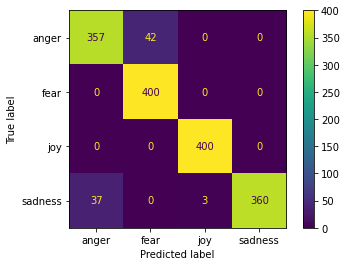

In [ ]:
def revert_oh(x):
  emotions = ['anger', 'fear', 'joy', 'sadness']
  return emotions[x]

# decode the predictions
y_preds = np.argmax(preds_output.predictions, axis=1)
y_preds_v = list(map(revert_oh, y_preds))
# encoded labels
y_true = np.array(dataset_encoded['test']['label'])
y_true_v = list(map(revert_oh, y_true))


cm = confusion_matrix(y_true_v, y_preds_v)
cmd_obj = ConfusionMatrixDisplay(cm, display_labels=['anger', 'fear', 'joy', 'sadness'])
cmd_obj.plot()

Let's convert Dataset object back to Pandas DataFrame for convenience:

In [ ]:
dataset_encoded['test'].set_format(type='pandas') 
test_df = dataset_encoded['test'][:]
# attach the predicted labels to the dataframe:
test_df['predicted_label'] = y_preds
test_df['predicted_emotion'] = y_preds_v

In [ ]:
misclassified = test_df[test_df['Emotion']!=test_df['predicted_emotion']]
print(f'There are {len(misclassified)} misclassified examples out of {len(test_df)} examples in the test set in total.')
print(f"Out of the 82 misclassified examples {len(misclassified[misclassified['Race']=='African-American'])} belong to African-American people and {len(misclassified)-len(misclassified[misclassified['Race']=='African-American'])} belong to European people.")
print(f"Out of the 82 misclassified examples {len(misclassified[misclassified['Gender']=='male'])} belong to men and {len(misclassified[misclassified['Gender']=='female'])} belong to women.")

There are 82 misclassified examples out of 1599 examples in the test set in total.
Out of the 82 misclassified examples 50 belong to African-American people and 32 belong to European people.
Out of the 82 misclassified examples 41 belong to men and 41 belong to women.


Check results by focusing on GENDER:

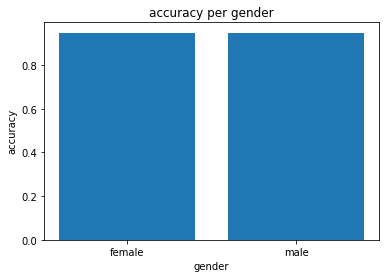

In [ ]:
female = test_df[test_df['Gender']=='female']
male = test_df[test_df['Gender']=='male']
female_acc = accuracy_score(female['Emotion'],female['predicted_emotion'])
male_acc = accuracy_score(male['Emotion'],male['predicted_emotion'])
plt.bar(['female', 'male'], [female_acc, male_acc])
plt.title('accuracy per gender')
plt.xlabel('gender')
plt.ylabel('accuracy')
plt.show()

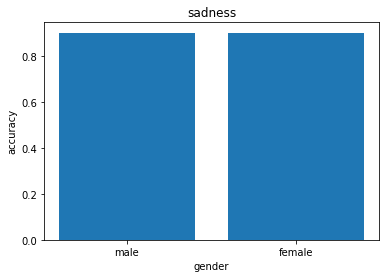

In [ ]:
EMOTION='sadness'

def check_specific_emotion(emotion):
  male = test_df[(test_df['Emotion']==f'{emotion}') & (test_df['Gender']=='male')]
  female = test_df[(test_df['Emotion']==f'{emotion}') & (test_df['Gender']=='female')]
  female_acc = accuracy_score(female['Emotion'], female['predicted_emotion'])
  male_acc = accuracy_score(male['Emotion'], male['predicted_emotion'])
  return female_acc, male_acc

gender = ['male','female']
female_acc, male_acc = check_specific_emotion(EMOTION)

plt.bar(gender, [female_acc, male_acc])
plt.title(f'{EMOTION}')
plt.xlabel('gender')
plt.ylabel('accuracy')
plt.show()

Check results by focusing on RACE:

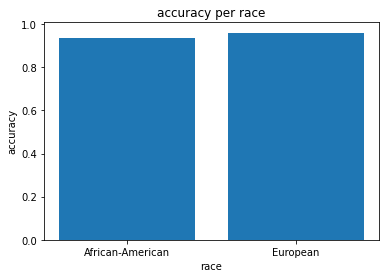

In [ ]:
am = test_df[test_df['Race']=='African-American']
eu = test_df[test_df['Race']=='European']
am_acc = accuracy_score(am['Emotion'],am['predicted_emotion'])
eu_acc = accuracy_score(eu['Emotion'],eu['predicted_emotion'])
plt.bar(['African-American', 'European'], [am_acc, eu_acc])
plt.title('accuracy per race')
plt.xlabel('race')
plt.ylabel('accuracy')
plt.show()

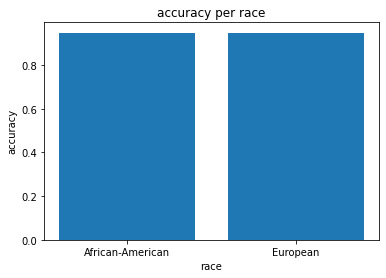

In [ ]:
EMOTION='fear'

def check_specific_emotion(emotion):
  am = test_df[(test_df['Emotion']==f'{emotion}') & (test_df['Race']=='male')]
  eu = test_df[(test_df['Emotion']==f'{emotion}') & (test_df['Race']=='female')]
  female_acc = accuracy_score(female['Emotion'], female['predicted_emotion'])
  male_acc = accuracy_score(male['Emotion'], male['predicted_emotion'])
  return female_acc, male_acc

am_acc, eu_acc = check_specific_emotion(EMOTION)

plt.title(f'{EMOTION}')
plt.bar(['African-American', 'European'], [am_acc, eu_acc])
plt.title('accuracy per race')
plt.xlabel('race')
plt.ylabel('accuracy')
plt.show()

Confusion matrix for African-American:

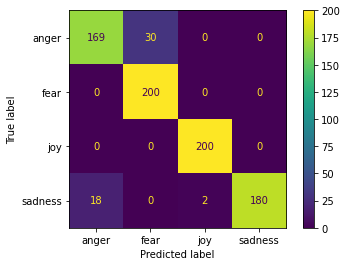

In [ ]:
cm_am = confusion_matrix(am['Emotion'], am['predicted_emotion'])
cmd_obj = ConfusionMatrixDisplay(cm_am, display_labels=['anger', 'fear', 'joy', 'sadness'])
cmd_obj.plot()

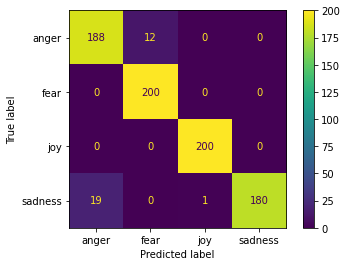

In [ ]:
cm_eu = confusion_matrix(eu['Emotion'], eu['predicted_emotion'])
cmd_obj = ConfusionMatrixDisplay(cm_eu, display_labels=['anger', 'fear', 'joy', 'sadness'])
cmd_obj.plot()